## Variational inference in Dirichlet Process Normal Mixture

In [1]:
import autograd
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp
import DP_normal_mixture_opt_lib as dp_opt

from copy import deepcopy

from scipy import optimize

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [2]:
np.random.seed(489027)
# np.random.seed(54325)

# data parameters
num_obs = 1000 # number of observations 
x_dim = 2 # dimension of observations
k_true = 5 # true number of clusters

info_x = 0.1 * np.eye(x_dim) 

x, true_mu, true_z, true_pi = dp.draw_data(info_x, x_dim, k_true, num_obs)


# prior parameters
alpha = 2.0 # DP parameter
prior_mu = np.mean(x, axis = 0)
prior_info = 0.1 * np.eye(x_dim)

# variational truncation 
k_approx = 10 



observed mixture proportions: 
 [ 0.191  0.216  0.201  0.208  0.184]
true mixture proportions: 
 [ 0.2  0.2  0.2  0.2  0.2]


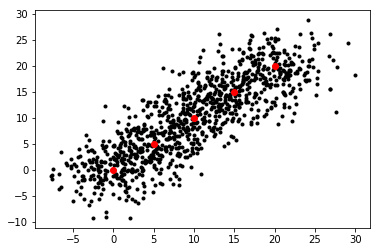

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

# Set up VB model

In [4]:
global_params = ModelParamsDict('global')
global_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)


In [5]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='prior_mu', size=x_dim, val=prior_mu))
prior_params.push_param(PosDefMatrixParam(name='prior_info', size=x_dim, val=prior_info))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

In [6]:
model = dp.DPNormalMixture(x, vb_params, prior_params)

# Initialize

In [7]:
## initialize VB params

true_init = False

if true_init: 
    true_tau = np.zeros(np.shape(vb_params['global']['v_sticks'].alpha.get()))
    true_tau[:,0] = true_v[:-1] * 100
    true_tau[:,1] = (1 - true_v[:-1]) * 100
    vb_params['global']['v_sticks'].alpha.set(true_tau)

    # vb_params['global']['mu'].set(true_mu)
    mu_size = vb_params['global']['mu'].free_size()
    vb_params['global']['mu'].set_free(np.random.random(mu_size))
    
    true_z_fudged = dp.soft_thresh(true_z, 1 - 10**(-8), 10**(-8))
    vb_params['local']['e_z'].set(true_z_fudged)
    # z_size = vb_params['local']['e_z'].free_size()
    # vb_params['local']['e_z'].set_free(np.random.random(z_size))
else: 
    vb_params.set_free(np.random.random(vb_params.free_size()))
    
init_free_params = vb_params.get_free()
global_init_free_params = vb_params['global'].get_free()

# Run CAVI 

CAVI terminated successfully :)
iterations ran:  435
elbo:  -13555.6238825


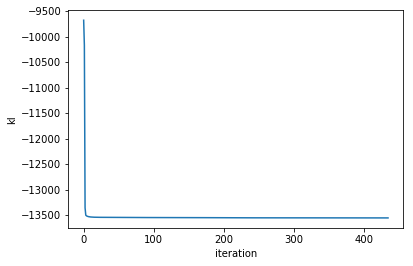

In [8]:
dp_opt.run_cavi(model, init_free_params, max_iter = 1000, tol = 1e-5, disp = False)
cavi_results = deepcopy(model)
print('elbo: ', cavi_results.get_kl())


### examine results of CAVI

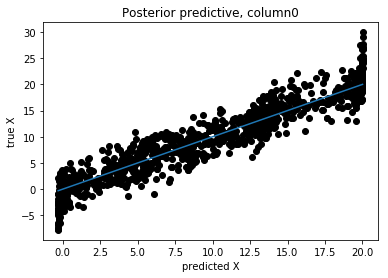

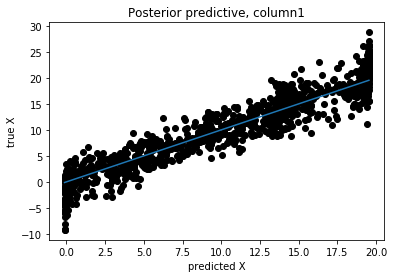

In [9]:
# plot posterior predictive
e_z = cavi_results.vb_params['local']['e_z'].get()
mu = cavi_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [10]:
# lets look at the estimated mixture proportions

tau = cavi_results.vb_params['global']['v_sticks'].alpha.get() 
post_stick_length = tau[:,0] / np.sum(tau, axis = 1) # mean posterior stick lengths

# compute mixture proportions using mean posterior stick lengths
post_pi = np.ones(k_approx)
stick_remain = np.ones(k_approx - 1)
for i in range(k_approx - 1):
    post_pi[i] = stick_remain[i - 1] * post_stick_length[i]
    stick_remain[i] = stick_remain[i - 1] * (1 - post_stick_length[i])
post_pi[-1] = stick_remain[-1]
assert(np.abs(np.sum(post_pi) - 1.) < 10**(-10))

print('true_proportions', true_pi)
print('estimated proportions: ', post_pi, '\n')

heavy_clusters = post_pi > 1 / k_approx # clusters with significant weights 

print('true number of clusters: ', k_true)
print('number of "posterior clusters" (ie. no. clusters w/ siginifcant weights): ', np.sum(post_pi > 1 / k_approx))
print('recall variational truncation: ', k_approx)

true_proportions [ 0.2  0.2  0.2  0.2  0.2]
estimated proportions:  [ 0.00163023  0.15935598  0.21094637  0.24128045  0.00160354  0.19353078
  0.00157218  0.00155229  0.00153302  0.18699515] 

true number of clusters:  5
number of "posterior clusters" (ie. no. clusters w/ siginifcant weights):  5
recall variational truncation:  10


In [11]:
# lets look at posterior means
print('true means: ')
print(true_mu, '\n')

print('relevant posterior means (ie. posterior means for clusters with significant weights): ')
post_mean = cavi_results.vb_params['global']['mu'].get()[heavy_clusters, :]
print(post_mean)

true means: 
[[ 0  0]
 [ 5  5]
 [10 10]
 [15 15]
 [20 20]] 

relevant posterior means (ie. posterior means for clusters with significant weights): 
[[  8.5434351    9.49999957]
 [ 20.00808841  19.5286746 ]
 [ 13.60526354  14.06215498]
 [ -0.30958516  -0.12611372]
 [  4.78306839   4.4838817 ]]


here, black are data points. red are the true means. blue are the posterior means


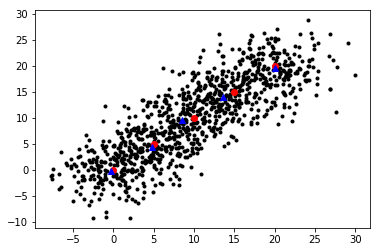

In [12]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')

print('here, black are data points. red are the true means. blue are the posterior means')

# Newton Optimization

In [13]:
kl_obj = Objective(model.vb_params['global'], model.kl_optimize_z)

In [14]:
def minimize_kl(kl_obj, init_x, maxiter = 50, gtol = 1e-8, disp = True):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hessp=kl_obj.fun_free_hvp,
        method='trust-ncg', options={'maxiter': maxiter, 'gtol': gtol, 'disp': disp})

    print('done :o')
    return vb_opt

newton_tr_init = cavi_results.vb_params['global'].get_free() # initialize with result from CAVI
newton_tr_opt = minimize_kl(kl_obj, newton_tr_init) # run Newton

         Current function value: -13555.623990
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 4
         Hessian evaluations: 0
done :o


In [15]:
model.vb_params['global'].set_free(newton_tr_opt.x)
model.set_optimal_z()

newton_results = deepcopy(model)

In [16]:
# checking the optima

print('minimizing function value', newton_results.get_kl())

# check that the gradient is close to 0
kl_grad = kl_obj.fun_free_grad(newton_tr_opt.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj.fun_free_hessian(newton_tr_opt.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian eigenvalues all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

minimizing function value -13555.6239911
L_inf norm of gradient:  9.89062038328e-08
time to compute Hessian (sec):  8.890918970108032
Hessian eigenvalues all positive:  True
distance (l2) to minimizer of quadratic approx. :  3.42271025495e-07


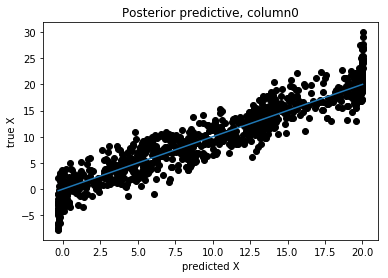

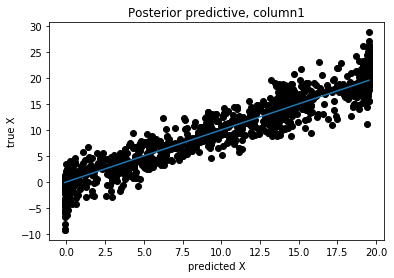

In [17]:
# plot posterior predictive
e_z = newton_results.vb_params['local']['e_z'].get()
mu = newton_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [18]:
# compare CAVI with Newton_tr
print(cavi_results.vb_params['global']['mu'].get())
print(newton_results.vb_params['global']['mu'].get())

print('l1 difference (normalized) between means: ', \
      np.mean(np.abs(cavi_results.vb_params['global']['mu'].get() \
                     - newton_results.vb_params['global']['mu'].get())))

[[  9.7259331    9.89728744]
 [  8.5434351    9.49999957]
 [ 20.00808841  19.5286746 ]
 [ 13.60526354  14.06215498]
 [  9.72651009   9.8971047 ]
 [ -0.30958516  -0.12611372]
 [  9.72719032   9.89688891]
 [  9.7276136    9.89675429]
 [  9.72801971   9.89662491]
 [  4.78306839   4.4838817 ]]
[[  9.72604325   9.89746555]
 [  8.53619746   9.49044896]
 [ 20.00814976  19.5286264 ]
 [ 13.60399888  14.0615522 ]
 [  9.72662714   9.89727491]
 [ -0.31213076  -0.12805524]
 [  9.72729395   9.89705672]
 [  9.72771515   9.89691861]
 [  9.7281193    9.8967859 ]
 [  4.77549568   4.47495984]]
l1 difference (normalized) between means:  0.00205601616828


In [19]:
print('l1 difference (normalized) between all params: ', \
      np.mean(np.abs(cavi_results.vb_params.get_free() - newton_results.vb_params.get_free())))

l1 difference (normalized) between all params:  0.0034958573648


# Parametric sensitivity analysis

In particular, we are interested in how posterior quantities depend on our choice of DP parameter $\alpha$. 

As a first step, lets manually perturb $\alpha$ and re-optimize. We'll then compare these perturbed results with the sensitivity predicted by LRVB. 

In [20]:
epsilon = 0.1 # how much we will perturb alpha

model_perturbed = deepcopy(newton_results)
model_perturbed.alpha = alpha + epsilon # perturb dp parameter

# define new objective
kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

# find new optima
newton_tr_opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x, gtol = 10**(-6))

model_perturbed.vb_params['global'].set_free(newton_tr_opt_perturbed.x) 
model_perturbed.set_optimal_z()

Optimization terminated successfully.
         Current function value: -13555.456139
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 0
done :o


In [21]:
# checking the optima

# check that the gradient is close to 0
kl_grad = kl_obj_perturbed.fun_free_grad(newton_tr_opt_perturbed.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj_perturbed.fun_free_hessian(newton_tr_opt_perturbed.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian evals all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

L_inf norm of gradient:  1.47878111261e-07
time to compute Hessian (sec):  9.131224870681763
Hessian evals all positive:  True
distance (l2) to minimizer of quadratic approx. :  6.23292458976e-07


Now, lets do LRVB and get predicted sensitivities for various posterior quantities

In [22]:
class DPNormalMixtureLRVB(object): 
    def __init__(self, model, interesting_moments): 
        self.model = deepcopy(model)
        self.alpha = model.alpha
        
        # this is a function that returns the moments you want for sensitivity analysis
        self.interesting_moments = deepcopy(interesting_moments)
        
        self.get_moment_jac = autograd.jacobian(self.get_interesting_moments)        
        self.get_kl_hessian = autograd.hessian(self.kl, argnum = 0)
        
        self.get_kl_jac = autograd.jacobian(self.kl, argnum = 0)
        self.get_alpha_jac = autograd.jacobian(self.get_kl_jac, argnum = 1)
        
    def get_interesting_moments(self, global_free_params):
        self.model.vb_params['global'].set_free(global_free_params)  
        self.model.set_optimal_z()
        
        return self.interesting_moments(self.model)
    
    def kl(self, global_free_params, alpha):
        self.model.vb_params['global'].set_free(global_free_params)
        self.model.alpha = alpha
        
        return self.model.kl_optimize_z()
    
    def get_sensitivity(self, optimal_global_free_params): 
        moment_jac = self.get_moment_jac(optimal_global_free_params)
        kl_hessian = self.get_kl_hessian(optimal_global_free_params, self.alpha)
        
        sensitivity_operator = np.linalg.solve(kl_hessian, moment_jac.T)
                                               
        alpha_jac = self.get_alpha_jac(optimal_global_free_params, self.alpha)

        return np.dot(sensitivity_operator.T, -1 * alpha_jac)

### V_stick sensitivity

As a first pass, we look at the sensitivity of the posterior stick lengths to our choice of DP parameter $\alpha$

In [23]:
def get_v_sticks(model): 
    # this is the posterior moment we will examine first
    return model.vb_params['global']['v_sticks'].e()[:,0]

# compute LRVB sensitivity
v_sticks_sensitivity = DPNormalMixtureLRVB(model, get_v_sticks)
lrvb_sens_v_sticks = v_sticks_sensitivity.get_sensitivity(newton_tr_opt.x)

print('LRVB predicted_sensitivity: \n', lrvb_sens_v_sticks)

# true senstivity
perturbed_mean = model_perturbed.vb_params['global']['v_sticks'].e()[:,0]
old_mean = newton_results.vb_params['global']['v_sticks'].e()[:,0]

print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

LRVB predicted_sensitivity: 
 [ -1.18557011e-06  -1.76643374e-03  -1.17344572e-03  -4.64541884e-03
  -4.91589552e-05  -8.65277143e-03  -2.36873120e-04  -2.34890492e-04
  -2.33054431e-04]
true sensitivity: 
 [ -1.18347012e-06  -1.74993062e-03  -1.16364351e-03  -4.60968138e-03
  -4.87358661e-05  -8.57696020e-03  -2.34431182e-04  -2.32471364e-04
  -2.30651770e-04]


### Cluster mean sensitivity

We can also check the sensitivity of posterior means to $\alpha$. 

In [24]:
def get_cluster_means(model): 
    return model.vb_params['global']['mu'].get_vector()

# compute LRVB sensitivity
cluster_means_sensitivity = DPNormalMixtureLRVB(model, get_cluster_means)
lrvb_sens_means = cluster_means_sensitivity.get_sensitivity(newton_tr_opt.x)

print('LRVB predicted_sensitivity: \n', lrvb_sens_means)

# true senstivity
perturbed_mean = model_perturbed.vb_params['global']['mu'].get_vector()
old_mean = newton_results.vb_params['global']['mu'].get_vector()

print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

LRVB predicted_sensitivity: 
 [-0.00020817 -0.00059323  0.08927744  0.10298754  0.00335929  0.00385467
  0.02608478  0.01887399 -0.00020591 -0.00057678 -0.01510713 -0.01596194
 -0.00021404 -0.00055449 -0.00022107 -0.00053978 -0.0002274  -0.0005258
  0.01895514  0.03688417]
true sensitivity: 
 [-0.00019553 -0.00057322  0.08853652  0.10213949  0.0033154   0.0038114
  0.02584749  0.01868224 -0.0001939  -0.00055694 -0.01498685 -0.01583378
 -0.00020219 -0.00053537 -0.00020941 -0.00052103 -0.00021591 -0.00050741
  0.0188255   0.03655909]


### Co-clustering sensitivity

Since this is a clustering problem, we can check other moments too: like co-clustering. In particular, for two data points indexed by $n_1$ and $n_2$, we can check the sensitivty of $E[z_{n_1, k} \cdot z_{n_2, k}]$, the indicator that $x_{n_1}$ and $x_{n_2}$ belong to the same cluster.

In [25]:
def get_co_clustering(model, n1, n2): 
    # this is the interesting posterior moment
    e_z1 = model.vb_params['local']['e_z'].get()[n1, :]
    e_z2 = model.vb_params['local']['e_z'].get()[n2, :]
    
    return e_z1 * e_z2

cluster of first data point:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster of second data point:  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
cluster mean of first data point:  [ 8.5434351   9.49999957]
cluster mean of first data point:  [ 20.00808841  19.5286746 ]

here, black are data points. red are the true means. 
blue are the posterior means. green are the chosen data points. 


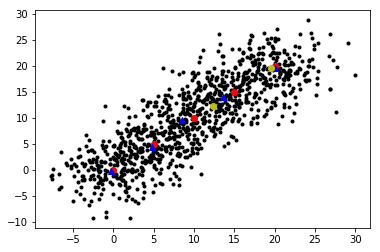

In [26]:
# choose two data points
n1 = 0
n2 = 7

cluster1 = np.round(model.vb_params['local']['e_z'].get()[n1, :])
cluster2 = np.round(model.vb_params['local']['e_z'].get()[n2, :])

print('cluster of first data point: ', cluster1)
print('cluster of second data point: ', cluster2)
print('cluster mean of first data point: ', np.dot(cluster1, cavi_results.vb_params['global']['mu'].get()))
print('cluster mean of first data point: ', np.dot(cluster2, cavi_results.vb_params['global']['mu'].get()))

# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')
    
plt.plot(x[n1, 0], x[n1, 0], 'yo')
plt.plot(x[n2, 0], x[n2, 0], 'yo')

print('\nhere, black are data points. red are the true means. ')
print('blue are the posterior means. green are the chosen data points. ')

co_clustering_sensitivity = DPNormalMixtureLRVB(model, lambda x: get_co_clustering(x, n1, n2))

In [27]:
print('sensitivity of co-clustering to alpha: ')
lrvb_sens_co_cluster = co_clustering_sensitivity.get_sensitivity(newton_tr_opt.x)

print('predicted_sensitivity: \n', lrvb_sens_co_cluster)

print('max sensitivity: ', np.max(np.abs(lrvb_sens_co_cluster)))

sensitivity of co-clustering to alpha: 
predicted_sensitivity: 
 [  7.59409771e-12   1.84862498e-05  -7.70458374e-07  -4.72103691e-04
   1.05632286e-11  -8.97818433e-21   2.36602518e-11   3.32100710e-11
   4.15922837e-11   1.40607735e-10]
max sensitivity:  0.000472103690613


cluster of first data point:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
cluster of second data point:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
cluster mean of first data point:  [ 8.5434351   9.49999957]
cluster mean of first data point:  [ 13.60526354  14.06215498]

here, black are data points. red are the true means. 
blue are the posterior means. green are the chosen data points. 


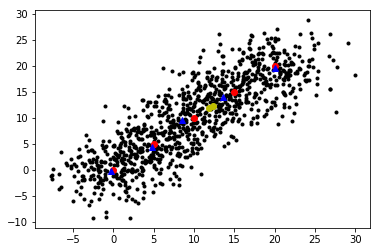

In [28]:
# choose two data points
n1 = 0
n2 = 13

cluster1 = np.round(model.vb_params['local']['e_z'].get()[n1, :])
cluster2 = np.round(model.vb_params['local']['e_z'].get()[n2, :])

print('cluster of first data point: ', cluster1)
print('cluster of second data point: ', cluster2)
print('cluster mean of first data point: ', np.dot(cluster1, cavi_results.vb_params['global']['mu'].get()))
print('cluster mean of first data point: ', np.dot(cluster2, cavi_results.vb_params['global']['mu'].get()))

# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

for k in range(np.shape(post_mean)[0]):
    plt.plot(post_mean[k, 0], post_mean[k, 1], 'b^')
    
plt.plot(x[n1, 0], x[n1, 0], 'yo')
plt.plot(x[n2, 0], x[n2, 0], 'yo')

print('\nhere, black are data points. red are the true means. ')
print('blue are the posterior means. green are the chosen data points. ')

co_clustering_sensitivity = DPNormalMixtureLRVB(model, lambda x: get_co_clustering(x, n1, n2))

In [29]:
print('sensitivity of co-clustering to alpha: ')
lrvb_sens_co_cluster = co_clustering_sensitivity.get_sensitivity(newton_tr_opt.x)

print('predicted_sensitivity: \n', lrvb_sens_co_cluster)

print('max sensitivity: ', np.max(np.abs(lrvb_sens_co_cluster)))

sensitivity of co-clustering to alpha: 
predicted_sensitivity: 
 [ -1.93444831e-08   8.42149173e-03  -1.11607083e-09  -6.61683419e-03
  -1.58810650e-08  -5.30350385e-12  -4.54517670e-09   3.56743600e-09
   1.07381405e-08   9.41736664e-05]
max sensitivity:  0.00842149172788


so we see that the co-clustering of two data points which are close is more sensitive to alpha than two data points that are far away

### now lets check this against our manual perturbation

In [30]:
co_clustering = newton_results.vb_params['local']['e_z'].get()[n1, :] \
    * newton_results.vb_params['local']['e_z'].get()[n2, :]
    
co_clustering_pert = model_perturbed.vb_params['local']['e_z'].get()[n1, :] * \
    model_perturbed.vb_params['local']['e_z'].get()[n2, :]

print('predicted_sensitivity: \n', lrvb_sens_co_cluster)
print('true_sensitivty: \n', (co_clustering_pert - co_clustering)/ epsilon)

predicted_sensitivity: 
 [ -1.93444831e-08   8.42149173e-03  -1.11607083e-09  -6.61683419e-03
  -1.58810650e-08  -5.30350385e-12  -4.54517670e-09   3.56743600e-09
   1.07381405e-08   9.41736664e-05]
true_sensitivty: 
 [ -1.87763578e-08   8.33022778e-03  -1.10068398e-09  -6.54076175e-03
  -1.53269172e-08  -5.23815914e-12  -4.19104171e-09   3.81812355e-09
   1.09134245e-08   9.39485897e-05]


## Let us check the linearity of the perturbation in alpha

In [31]:
epsilons = np.arange(-1.0, 1.0, 0.2) # the range with which we will evaluate alpha

results = np.zeros((len(epsilons), model.vb_params.free_size()))

for i in range(len(epsilons)): 
    print(epsilons[i])
    model_perturbed = deepcopy(newton_results)
    model_perturbed.alpha  = alpha + epsilons[i] # perturb dp parameter

    # define new objective
    kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

    # find new optima
    opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x, gtol = 10**(-6), disp = False)
    
    # set to optima
    model_perturbed.vb_params['global'].set_free(opt_perturbed.x) 
    model_perturbed.set_optimal_z()
    
    results[i, :] = model_perturbed.vb_params.get_free()    

-1.0
done :o
-0.8
done :o
-0.6
done :o
-0.4
done :o
-0.2
done :o
-2.22044604925e-16
done :o
0.2
done :o
0.4
done :o
0.6
done :o
0.8
done :o


In [32]:
k_stick = 1
k_co_cluster = 3

perturbed_v_sticks = np.zeros(len(epsilons))
perturbed_co_clusters = np.zeros(len(epsilons))

for i in range(len(epsilons)): 
    model.vb_params.set_free(results[i,:])
    perturbed_v_sticks[i] = model.vb_params['global']['v_sticks'].e()[k_stick, 0]
    
    tmp = model.vb_params['local']['e_z'].get()[n1, :] * \
                                model.vb_params['local']['e_z'].get()[n2, :]
    perturbed_co_clusters[i] = tmp[k_co_cluster]

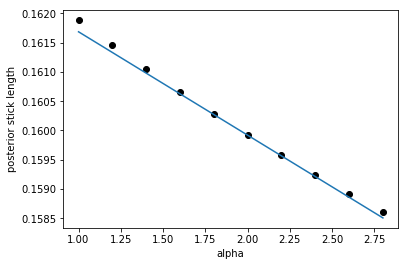

In [33]:
plt.plot(alpha + epsilons, perturbed_v_sticks, 'ko')
# plot the LRVB approximation
x_axis = np.linspace(alpha + epsilons[0], alpha + epsilons[-1], 100)

old_mean = newton_results.vb_params['global']['v_sticks'].e()[k_stick, 0]
plt.plot(x_axis, lrvb_sens_v_sticks[k_stick] * (x_axis - alpha) + old_mean)
plt.xlabel('alpha')
plt.ylabel('posterior stick length')

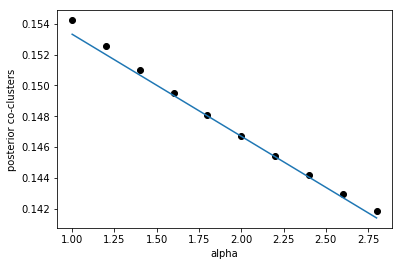

In [34]:
plt.plot(alpha + epsilons, perturbed_co_clusters, 'ko')

# plot the LRVB approximation
x_axis = np.linspace(alpha + epsilons[0], alpha + epsilons[-1], 100)

old_co_cluster = newton_results.vb_params['local']['e_z'].get()[n1, :] * \
                                newton_results.vb_params['local']['e_z'].get()[n2, :]
plt.plot(x_axis, lrvb_sens_co_cluster[k_co_cluster] * (x_axis - alpha) + old_co_cluster[k_co_cluster])
plt.xlabel('alpha')
plt.ylabel('posterior co-clusters')